# Multi Objective Evolutionary Algorithms (Part 1)

This chapter continues our consideration of evolutionary algorithms, but generalises to the case where we have more than one objective. First we need to import the usual stuff, and some new libraries so we can look at animations of the search:

In [1]:
import sys
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## The Next Release Problem

As an example problem instance, we consider the Next Release Problem (NRP), which relates to the problem of balancing customer profits and requirements costs in requirements engineering. The aim is to maximise customer profits from a set of dependent requirements, under the constraints of a predefined budget bound. A solution to the NRP problem can inform a requirements engineer when making  a decision for software requirements to balance the profits of the company and the customers.

NRP is a classical problem in software engineering, and we will use example datasets taken from http://cstar.whu.edu.cn/p/nrp/. To represent a concrete NRP task, we need to represent the following information:
- For each requirement we need to store its cost
- For each requirement we need to store its dependencies (i.e. other requirements that need to be satisfied first)
- For each customer we need to store a weight that represents the importance of that customer
- For each customer we need to store the list of requirements that they desire

In [2]:
profit_map = {}        # customer id => weight
requirements_map = {}  # customer id => [ requirement_id * ]
cost_map = {}          # requirement id => cost
dependency_map = {}    # requirement id => [ requirement_id * ]
num_requirements = 140

We will use the standard interchance format for NRP problems (http://cstar.whu.edu.cn/p/nrp/), which looks as follows (taken from the `readme.txt`):

```
3
^ Level of requirements, t
20
^ Number of requirements in Level 1
4 3 4 1 5 5 5 3 5 3 4 4 3 5 1 1 3 2 2 3
^ Costs of requirements in Level 1 (the number is 20)
40
^ Number of requirements in Level 2
8 8 2 6 7 4 5 3 6 3 7 2 6 3 5 2 2 4 2 5 4 5 2 2 8 4 2 4 8 7 3 6 6 4 3 6 4 8 6 7
^ Costs of requirements in Level 2 (the number is 40)
80
^ Number of requirements in Level 3
9 6 10 6 9 10 7 9 7 6 10 6 5 10 5 6 6 6 5 6 8 10 9 6 10 7 10 8 9 9 6 10 8 8 10 10 6 7 6 8 7 10
^ Costs of requirements in Level 3 (the number is 80)
97
^ Number of dependencies
1 85
^ Id of RequirementA1   Id of RequirementB1
2 98
^ Id of RequirementA2   Id of RequirementB2
2 37
2 92
...
```

To parse these files we define a helper function:

In [3]:
def parse_nrp(filename):

    with open(filename) as fp:
        levels   = int(fp.readline())
        req_id = 1
        for level in range(levels):
            num_reqs = int(fp.readline())
            for cost in fp.readline().split():
                cost_map[req_id] = int(cost)
                req_id += 1
        total_deps = int(fp.readline())
        for num_dep in range(total_deps):
            r1, r2 = fp.readline().split()
            r1_id = int(r1)
            if r1_id in dependency_map:
                dependency_map[int(r1)].append(int(r2))
            else:
                dependency_map[int(r1)] = [int(r2)]

        total_customers = int(fp.readline())
        for num_cust in range(total_customers):
            customer = fp.readline().split()
            profit_map[num_cust + 1] = int(customer[0])
            num_reqs = int(customer[1])
            requirements = []
            for num_req in range(num_reqs):
                requirements.append(int(customer[2+num_req]))
            requirements_map[num_cust + 1] = requirements

        num_requirements = len(cost_map)

    print("Cost: {}".format(cost_map))
    print("Dependencies: {}".format(dependency_map))
    print("Profit: {}".format(profit_map))
    print("Requirements: {}".format(requirements_map))
    print("Num requirements: {}".format(num_requirements))

As running example, we will use the small instance `nrp1.txt`:

In [4]:
parse_nrp("data/nrp/nrp1.txt")

Cost: {1: 4, 2: 3, 3: 4, 4: 1, 5: 5, 6: 5, 7: 5, 8: 3, 9: 5, 10: 3, 11: 4, 12: 4, 13: 3, 14: 5, 15: 1, 16: 1, 17: 3, 18: 2, 19: 2, 20: 3, 21: 8, 22: 8, 23: 2, 24: 6, 25: 7, 26: 4, 27: 5, 28: 3, 29: 6, 30: 3, 31: 7, 32: 2, 33: 6, 34: 3, 35: 5, 36: 2, 37: 2, 38: 4, 39: 2, 40: 5, 41: 4, 42: 5, 43: 2, 44: 2, 45: 8, 46: 4, 47: 2, 48: 4, 49: 8, 50: 7, 51: 3, 52: 6, 53: 6, 54: 4, 55: 3, 56: 6, 57: 4, 58: 8, 59: 6, 60: 7, 61: 9, 62: 6, 63: 10, 64: 6, 65: 9, 66: 10, 67: 7, 68: 9, 69: 7, 70: 6, 71: 10, 72: 6, 73: 5, 74: 10, 75: 5, 76: 6, 77: 6, 78: 6, 79: 5, 80: 6, 81: 8, 82: 10, 83: 9, 84: 6, 85: 10, 86: 7, 87: 10, 88: 8, 89: 9, 90: 9, 91: 6, 92: 10, 93: 8, 94: 8, 95: 10, 96: 10, 97: 6, 98: 7, 99: 6, 100: 8, 101: 7, 102: 10, 103: 7, 104: 9, 105: 6, 106: 6, 107: 8, 108: 6, 109: 7, 110: 8, 111: 7, 112: 7, 113: 6, 114: 7, 115: 9, 116: 6, 117: 7, 118: 6, 119: 8, 120: 6, 121: 6, 122: 7, 123: 5, 124: 7, 125: 5, 126: 8, 127: 9, 128: 10, 129: 10, 130: 6, 131: 5, 132: 9, 133: 8, 134: 10, 135: 7, 136: 8,

A solution to an NRP problem is a choice of requirements. We can simply represent this as a binary vector of the length of the number of requirements, and for each index in the vector we use `0` or `1` to denote whether the requirement is chosen or not. This is a classical way to represent subset-selection (Knapsack) problems.

In [5]:
def get_random_individual():
    individual = [random.choice([0,1]) for _ in range(num_requirements)]
    return individual

In [6]:
%pprint  # Turn off pretty printing to avoid waste of space
get_random_individual()

Pretty printing has been turned OFF


[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

We can also decode the individual to see the actual numbers of the requirements selected:

In [7]:
[i for i, x in enumerate(get_random_individual()) if x == 1]

[1, 2, 3, 4, 7, 8, 13, 19, 20, 26, 28, 29, 30, 31, 32, 37, 39, 43, 44, 45, 46, 48, 50, 53, 55, 56, 59, 67, 68, 70, 71, 72, 74, 76, 78, 81, 83, 84, 85, 87, 88, 89, 91, 94, 95, 96, 97, 100, 101, 102, 103, 104, 108, 110, 115, 116, 119, 120, 121, 122, 126, 128, 129, 131, 132, 135, 137, 138, 139]

In [8]:
%pprint  # Turn pretty printing back on now that we're done with long lists

Pretty printing has been turned ON


Since our representation is identical to the one we used for previous problems such as one max, we can also keep the same mutation function that implements simple bit flips:

In [9]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = solution[:]
    for position in range(len(solution)):
        if random.random() < P_mutate:
            mutated[position] = 1 - mutated[position]
    return mutated

The question of the fitness function, however, is slightly more tricky: There are actually two properties we would like to optimise. First, there is the profit, which we calculate as the sum of the weights of customers whose requirements are completely satisfied by the selection of requirements in a solution:

In [10]:
# Profit is the sum of the weights of customers whose requirements are satisfied
def function1(solution):
    fitness = 0

    requirements = set([x+1 for x in range(len(solution)) if solution[x] == 1])
    for customer_id in profit_map.keys():
        reqs = set(requirements_map[customer_id])
        if reqs.issubset(requirements):
            fitness += profit_map[customer_id]

    return fitness

The second dimension for optimisation are the costs. Obviously, the smaller the costs, the better for the company implementing the software system. We calculate the costs simply as the sum of the costs of the chosen requirements:

In [11]:
# Cost is the sum of costs of the implemented requirements
def function2(solution):
    cost = 0

    for i in range(num_requirements):
        if solution[i]:
            cost += cost_map[i+1]

    return cost

Note that we want to minimise, and not maximise, the costs. We do, however, know the worst possible fitness value for cost, which is simply the cost of selecting all requirements:

In [12]:
total_costs = sum([ cost_map[i+1] for i in range(num_requirements)])

In [13]:
total_profit = sum(profit_map.values())

There are also dependencies between the requirements -- we'll ignore these for now to keep the example simple. In principle, however, we would need to factor these in as well in some way. For example, we could always add dependencies before evaluating fitness, or we could include the degree to which dependencies are satisfied in the fitness calculation, or we could constraint our `get_random_individual` and `mutate` functions to only return solutions where dependencies are satisfied.

A random search would again consist of sampling a number of random solutions. Instead of looking at a single plot over time, however, the solutions are actually in a two-dimensional fitness space:

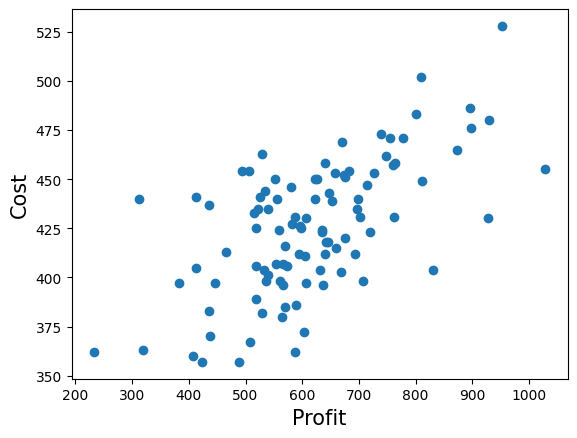

In [14]:
example_population = [get_random_individual() for _ in range(100)]
function1_values = [function1(x) for x in example_population]
function2_values = [function2(x) for x in example_population]
plt.xlabel('Profit', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.scatter(function1_values, function2_values)

There is a trade-off between cost and profit: More profitable solutions tend to also have higher costs; the lowest costs can be achieved by not implementing anything, which would also bring no profit. In this two-dimensional plot, solutions that are in the bottom right corner are the best, since they achieve high profit at low costs.

In the previous chapter, we noted that we are redundantly calculating fitness values. To make things more realistic, we are now going to cache fitness values in individuals. We will simply do this by adding a `fitness` field to an individual; if this isn't set, then fitness has not been calculated. In Python we can simply introduce new attributes to objects by setting them, but this does not hold for some built-in objects such as lists, which we've been using for all our representations so far. We will thus introduce a wrapper class for a list, simply for the sake of allowing us to cache fitness values:

In [15]:
class L(list):
    """
    A subclass of list that can accept additional attributes.
    Should be able to be used just like a regular list.
    """
    def __new__(self, *args, **kwargs):
        return super(L, self).__new__(self, args, kwargs)

    def __init__(self, *args, **kwargs):
        if len(args) == 1 and hasattr(args[0], '__iter__'):
            list.__init__(self, args[0])
        else:
            list.__init__(self, args)
        self.__dict__.update(kwargs)

    def __call__(self, **kwargs):
        self.__dict__.update(kwargs)
        return self

We can now store the fitness values of individuals as attributes of the objects

In [16]:
def evaluate(individual):
    individual.fitness1 = function1(individual)
    individual.fitness2 = function2(individual)

We will keep individuals immutable, such that mutation or crossover do not change any values and we never need to recalculate fitness values. But we need to update operations that produce new individuals to calculate the fitness value on these, i.e. when creating random individuals, and when mutating them (we do not need to evaluate fitness after crossover, since we always call `mutate` after crossover). We can now instantiate random individuals of NRP solutions using instances of `L` rather than lists:

In [17]:
def get_random_individual():
    individual = L(random.choice([0,1]) for _ in range(num_requirements))
    evaluate(individual)
    return individual

In [18]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = L(solution[:])
    for position in range(len(solution)):
        if random.random() < P_mutate:
            mutated[position] = 1 - mutated[position]
    evaluate(mutated)
    return mutated

We can check that the fields are set correctly:

In [19]:
x = get_random_individual()
print(f"Fitness 1: {x.fitness1}, fitness 2: {x.fitness2}")

Fitness 1: 726, fitness 2: 403


### Weighted Fitness

A basic way to apply metaheuristic search algorithms to problems such as NRP where we have more than one optimisation goal is to build a linear combination of the individual objective values to form a single fitness value. When doing this, one has to assign weights to measure the trade-off between the different objectives. We also need to take care in combining our two fitness values, as one is a maximisation problem and the other is a minimisation problem. We can convert the cost-function to a maximisation problem by deducting the costs from the `total_costs`:

In [20]:
def get_fitness(individual):
    # Maximise profit (fitness1), minimise cost (fitness 2)
    return 10*individual.fitness1 + (total_costs - individual.fitness2)

While we can look at the evolution of this fitness value over time, it is also of interest to see how the individual fitness values evolve independently. For this we need to look at a two-dimensional plot like above, for each iteration of the algorithm. To achieve this, we will produce an animation.

In [21]:
ims = []  # global variable to store images of the animation
fitness_values = []
    
def initialise_plot():
    global ims
    global fitness_values
    global fig
    global ax
    
    ims = []
    fitness_values = []

    %matplotlib agg
    fig, ax = plt.subplots()
    plt.xlabel('Profit', fontsize=15)
    plt.ylabel('Cost', fontsize=15)
    ims = []
    %matplotlib inline

For each iteration of the algorithm, we will update this animation with a snapshot of the current population and their fitness values:

In [22]:
def plot(population):
    function1_values = [x.fitness1 for x in population]
    function2_values = [x.fitness2 for x in population]
    
    ims.append((ax.scatter(function1_values, function2_values, color="blue"),))

We will start with a simple genetic algorithm again, which means we also need a selection operator:

In [23]:
tournament_size=3
def tournament_selection(population):
    candidates = random.sample(population, tournament_size)
    return max(candidates, key=lambda x:get_fitness(x))

Note that we do call `get_fitness` here again, but it just calculates the weighted sum of the already stored objective values, so we will not count it towards the total fitness evaluations.

We can also keep elitism unchanged without it requiring potentially costly fitness computations:

In [24]:
elite_size = 1
def elitism(population):
    population.sort(key=lambda k: get_fitness(k), reverse=True)
    return population[:elite_size]

Finally, we also need to update our crossover operator to use our wrapper `L` class. However, we don't need to calculate fitness here since this already happens in the mutation operator. (This is a simplifcation we can use in the specific algorithm we have implemented, and it may not generalise. More generally, one would use an explicit evaluation step in the search algorithm).

In [25]:
def crossover(parent1, parent2):
    pos = random.randint(0, len(parent1))
    offspring1 = L(parent1[:pos] + parent2[pos:])
    offspring2 = L(parent2[:pos] + parent1[pos:])
    return (offspring1, offspring2)

In [26]:
population_size = 20
P_xover = 0.7
max_gen = 100
selection = tournament_selection

We can update the genetic algorithm to use our updated functions, which reduces the clutter a bit compared to previous versions. Going forward, we will compare algorithms on multi-objective problems in terms of iterations rather than individual fitness evaluations, since we want to look at the evolution of the entire population.

In [27]:
def ga():
    initialise_plot()
    population = [get_random_individual() for _ in range(population_size)]
    best_fitness = -1
    for p in population:
        fitness = get_fitness(p)
        if fitness > best_fitness:
            best_fitness = fitness
        fitness_values.append(best_fitness)

    for iteration in range(max_gen):
        plot(population)
        new_population = elitism(population)
        while len(new_population) < len(population):
            parent1 = selection(population)
            parent2 = selection(population)

            if random.random() < P_xover:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)
            
            new_population.append(offspring1)
            new_population.append(offspring2)

        population = new_population
        for p in population:
            fitness = get_fitness(p)
            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = p
            fitness_values.append(best_fitness)

    plot([best_solution])

    return [best_solution]

Calling the genetic algorithm now will use the weighted combination defined above, which weights profit higher than costs.

In [28]:
fitness_values = []
ga()

[[1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0]]

The overall fitness values look like any other fitness function we have seen in the past.

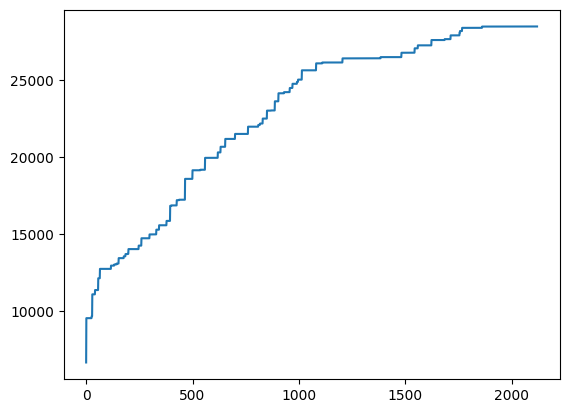

In [29]:
plt.plot(fitness_values)

To understand how the evolution affects the solutions with respect to the constituent objectives we need to consider their values over time (If you are looking at a PDF export, you will be missing this bit).

In [30]:
im_ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=3000, blit=True)
HTML(im_ani.to_jshtml())

Our weighted combination puts more focus on maximising profit than on minimising the costs, which you can see by the solutions moving towards the upper right corner of the plot. We can change the outcome of the search by changing that balance:

In [31]:
def get_fitness(individual):
    # Maximise profit (fitness1), minimise cost (fitness 2)
    return individual.fitness1 + 10*(total_costs - individual.fitness2)

In [32]:
result = ga()

Considering the combined fitness values there is no obvious difference except for the scale of the values:

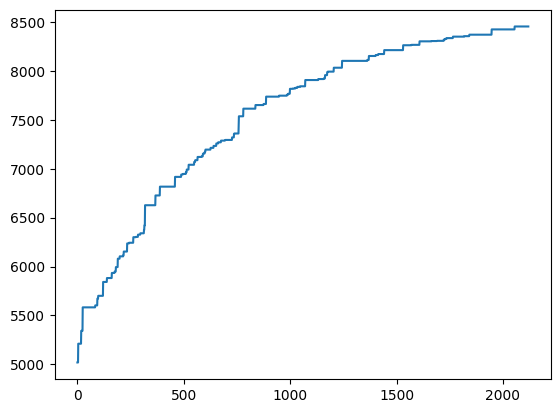

In [33]:
plt.plot(fitness_values)

Considering the evolution of both objectives is more telling again:

In [34]:
im_ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=3000, blit=True)
HTML(im_ani.to_jshtml())

The likely outcome is that using the adapted weights, when giving more preference to reducing costs, the resulting solution achieves little profit at all.

Maybe a better solution would be to use more similar weights for both components?

In [35]:
def get_fitness(individual):
    # Maximise profit (fitness1), minimise cost (fitness 2)
    return individual.fitness1 + 4 * (total_costs - individual.fitness2)

In [36]:
result = ga()

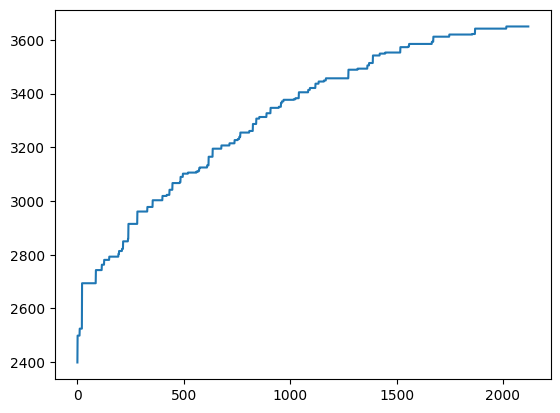

In [37]:
plt.plot(fitness_values)

In [38]:
im_ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=3000, blit=True)
HTML(im_ani.to_jshtml())

The result seems like a better compromise this time -- the profit increases, while the costs don't increase dramatically over time. Finding a balance in the weighting is not easy, and the solution we got in the end might not actually be a particularly good one.

## Pareto dominance

An individual Pareto-dominates another one if and only if it has a strictly better fitness value for at least one objective without having a worse fitness value for any other objectives. This condition can be simply implemented as follows for our scenario with two objective functions, but for the sake of the example we will assume two maximising fitness functions:

In [39]:
def dominates(solution1, solution2):
    """
     A solution x(1) is said to dominate the other solution x(2) if both condition 1 and 2 below are true:

     Condition 1: x(1) is no worse than x(2) for all objectives
     Condition 2: x(1) is strictly better than x(2) in at least one objective
    """
    if solution1.fitness1 < solution2.fitness1 or solution1.fitness2 < solution2.fitness2:
        return False

    if solution1.fitness1 > solution2.fitness1 or solution1.fitness2 > solution2.fitness2:
        return True

    return False

For example, consider the following dummy individuals:

In [40]:
x1 = L()
x1.fitness1 = 80
x1.fitness2 = 60

x2 = L()
x2.fitness1 = 60
x2.fitness2 = 80

Individuals `x1` and `x2` do not dominate each other: `x1` has a better fitness value for `fitness1` while `x2` has a better fitness value for `fitness2`.

In [41]:
dominates(x1, x2)

False

In [42]:
dominates(x2, x1)

False

In [43]:
x3 = L()
x3.fitness1 = 80
x3.fitness2 = 90

x4 = L()
x4.fitness1 = 90
x4.fitness2 = 80

Individual `x3` dominates both, `x1` and `x2`, as it is not worse in any of the fitness values, and it is better in at least one for each pair:

In [44]:
dominates(x3, x1)

True

In [45]:
dominates(x3, x2)

True

Individual `x4` also dominates `x1` and `x2`:

In [46]:
dominates(x4, x1)

True

In [47]:
dominates(x4, x2)

True

However, `x3` and `x4` do not dominate each other:

In [48]:
dominates(x4, x3)

False

In [49]:
dominates(x3, x4)

False

The solutions in a population can be sorted into Pareto _fronts_. Individuals within a front are non-dominating to each other. Fronts are sorted into levels; an individual in front _n_ is dominated by at least one individual in front _n-1_. The first front consists of solutions that are not dominated by any other candidate solutions.

/var/folders/f_/tkpv1l297b3cpc2byt1knvg80000gn/T/ipykernel_2822/350414198.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([x1.fitness1, x2.fitness1], [x1.fitness2, x2.fitness2], 'ro-', label="Front 2", color="blue")


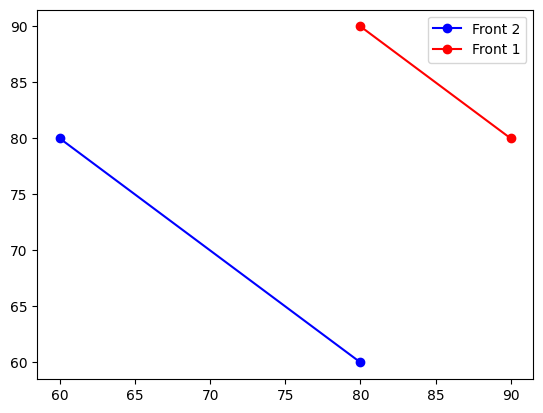

In [50]:
plt.plot([x1.fitness1, x2.fitness1], [x1.fitness2, x2.fitness2], 'ro-', label="Front 2", color="blue")
plt.plot([x3.fitness1, x4.fitness1], [x3.fitness2, x4.fitness2], 'ro-', label="Front 1")
plt.legend()

The principle of Pareto dominance is used by many multi-objective optimisation algorithms. The aim is to find a Pareto front that approximates the true Pareto front as closely as possible.

## NSGA-II

As an example multi-objective adaptation of a genetic algorithm, we will consider the non-dominating sorting genetic algorithm, in its second incarnation, NSGA-II. This is one of the most popular multi-objective optimisation algorithms, and it is explained in detail in the following paper:

K. Deb, A. Pratap, S. Agarwal, T. Meyarivan. A fast and elitist multiobjective genetic algorithm: NSGA-II. IEEE Transactions on Evolutionary Computation, 6(2), 182-197. 2002.

The overall workflow of the non-dominating sorting genetic algorithm (NSGA-II) is as follows, for each iteration of the algorithm:

1. Combine parent generation $P_i$ and offspring $O_i$
2. Sort combined population into Pareto fronts $F$
3. Create new generation $P_{t+1}$ as empty set
4. For each front in $F$: Copy front into $P_{t+1}$ if the entire front fits into $P_{t+1}$
5. Let $F_i$ be the first front that does not completely fit into $P_{t+1}$. Sort $F_i$ by crowding distance
6. Select the first $n$ individuals from $F_i$, if there are $n$ remaining places in $P_{t+1}$.
7. Create offspring population $Q_{t+1}$

The first aspect of this algorithm is the sorting of populations into Pareto fronts. This is done by determining for each individual in the population (1) how many other individuals it is dominated by, and (2) which individuals it dominates. Then, we can iteratively build fronts by selecting individuals that have a domination counter of 0, and reducing the domination counter of all the individuals they dominate by 1:

In [51]:
def fast_non_dominated_sort(solutions):
    front = [[]]

    S = [[] for _ in range(len(solutions))]
    n = [0 for _ in range(len(solutions))]

    for p in range(len(solutions)):
        S[p] = []
        n[p] = 0
        for q in range(len(solutions)):
            if dominates(solutions[p], solutions[q]):
                S[p].append(q)
            elif dominates(solutions[q], solutions[p]):
                n[p] = n[p] + 1

        if n[p] == 0:
            front[0].append(p)
            solutions[p].rank = 0

    i = 0
    while front[i]:
        Q = []
        for p in front[i]:
            for q in S[p]:
                n[q] = n[q] - 1
                if n[q] == 0:
                    Q.append(q)
                    solutions[q].rank = i + 1
        i = i + 1
        front.append(Q)

    del front[-1]
    return front

We are storing the rank in the current population in the attribute `rank`, which we will need later during selection.

We can try this using our example individuals from above:

In [52]:
fast_non_dominated_sort([x1, x2, x3, x4])

[[2, 3], [0, 1]]

As you can see, the algorithm returns the indices of the individuals rather than copies of the individuals.

The next new aspect of the NSGA-II algorithm occurs when the next front does not entirely fit into the next generation. In this case, we need to sort the next front by crowding distance, such that we can select the most diverse individuals. For each objective function we sort the individuals by their objective value. We then calculate a crowding distance value for each individual. The individuals with minimum and maximum fitness values are assigned a very large crowding distance to ensure they are ranked first (we just use a very large value of `4444444444444444` to ensure that). All other individuals are assigned the sum of distance values between their neighbours in objective space for all objectives:

In [53]:
def calculate_crowding_distance_and_sort(front):

    data = [(x, front[x].fitness1, front[x].fitness2) for x in range(len(front))]
    sorted1 = [(x, y) for (x, y, z) in sorted(data, key=lambda tup: tup[1])]
    sorted2 = [(x, z) for (x, y, z) in sorted(data, key=lambda tup: tup[2])]

    distance = [0 for _ in range(0,len(front))]
    range_fitness1 = max(x.fitness1 for x in front) - min(x.fitness1 for x in front)
    range_fitness2 = max(x.fitness2 for x in front) - min(x.fitness2 for x in front)

    distance[sorted1[0][0]] = sys.maxsize
    distance[sorted1[-1][0]] = sys.maxsize

    distance[sorted2[0][0]] = sys.maxsize
    distance[sorted2[-1][0]] = sys.maxsize

    for k in range(1,len(front)-1):
        index = sorted1[k][0]
        distance[index] = distance[index] + (sorted1[k+1][1] - sorted1[k-1][1]) / range_fitness1

    for k in range(1,len(front)-1):
        index = sorted2[k][0]
        distance[index] = distance[index] + (sorted2[k+1][1] - sorted2[k-1][1]) / range_fitness2

    for k in range(0, len(front)):
        front[k].distance = distance[k]

    front.sort(key = lambda i: i.distance, reverse=True)

The algorithm expects a front in terms of the actual individuals rather than indices. We need to extend our example fronts now though, because the individuals with the minimum and maximum value for each objective function are always sorted first, and the fronts in our previous examples consist only of two individuals each.

In [54]:
x1 = L(1)
x1.fitness1 = 90
x1.fitness2 = 50

x2 = L(2)
x2.fitness1 = 60
x2.fitness2 = 80

x3 = L(3)
x3.fitness1 = 80
x3.fitness2 = 60

x4 = L(4)
x4.fitness1 = 50
x4.fitness2 = 90

x5 = L(5)
x5.fitness1 = 92
x5.fitness2 = 95

x6 = L(6)
x6.fitness1 = 99
x6.fitness2 = 90

x7 = L(7)
x7.fitness1 = 99
x7.fitness2 = 90

x8 = L(8)
x8.fitness1 = 95
x8.fitness2 = 92

There are still two fronts in our example population:

In [55]:
fast_non_dominated_sort([x1, x2, x3, x4, x5, x6, x7, x8])

[[4, 5, 6, 7], [0, 1, 2, 3]]

To apply our sorting we need to pass in the actual individuals, in order to access their fitness values.

In [56]:
pop = [x1, x2, x3, x4, x5, x6, x7, x8]
front1 = [pop[index] for index in fast_non_dominated_sort(pop)[0]]
calculate_crowding_distance_and_sort(front1)

# Print population indices of sorted front1
[pop.index(x) for x in front1]

[5, 6, 4, 7]

The individuals at index 5 and 6 (`x6` and `x7`) are ranked first, because they are at the max and min of the fitness scores for the two objectives. The individuals `x4` and `x8` are ranked afterwards.

To generate an offspring population, NSGA-II uses binary tournament selection, but since there isn't a single fitness value to compare, the winner of the tournament is determined by the rank in the fronts as well as the crowding distance. An individual is selected if the rank is less than the rank of the other individual, or if the crowding distance is greater than that of the other individual.

In [57]:
def binary_rank_tournament(population):
    individual1 = random.choice(population)
    individual2 = random.choice(population)

    if individual1.rank < individual2.rank:
        return individual1
    elif individual1.rank > individual2.rank:
        return individual2
    else:
        return max([individual1, individual2], key = lambda i: i.distance)

The use of crowding distance during parent and survivor selection serves to increase diversity. To see whether this is achieved, we will keep track of population diversity again.

Besides this selection operator, crossover and mutation are applied as usual to derive a new generation:

In [58]:
def generate_offspring(population):
    offspring_population = []
    while len(offspring_population) < len(population):
        parent1 = binary_rank_tournament(population)
        parent2 = binary_rank_tournament(population)
        if random.random() < P_xover:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2
            
        offspring1 = mutate(offspring1)
        offspring2 = mutate(offspring2)

        offspring_population.append(offspring1)
        offspring_population.append(offspring2)

    return offspring_population

Since NSGA-II starts immediately by creating an offspring population, we require information about the ranks and crowding distance already for the initial population.

In [59]:
def get_initial_population(population_size):
    population = [get_random_individual() for _ in range(population_size)]
    fronts = fast_non_dominated_sort(population)
    
    for front_indices in fronts:
        front = [population[index] for index in front_indices]
        calculate_crowding_distance_and_sort(front)

    return population

Before we can apply NSGA-II on our NRP problem, we need to update the dominator relation, since we are maximising profit but minising costs (the previous definition of domination assumed maximisation of both objectives).

In [60]:
def dominates(solution1, solution2):
    """
     A solution x(1) is said to dominate the other solution x(2) if both condition 1 and 2 below are true:

     Condition 1: x(1) is no worse than x(2) for all objectives
     Condition 2: x(1) is strictly better than x(2) in at least one objective
     
     We are maximising fitness 1, but minimising fitness 2
    """
    if solution1.fitness1 < solution2.fitness1 or solution1.fitness2 > solution2.fitness2:
        return False

    if solution1.fitness1 > solution2.fitness1 or solution1.fitness2 < solution2.fitness2:
        return True

    return False

With this, we can implement the full algorithm.

In [61]:
def nsgaii():
    initialise_plot()
    population = get_initial_population(population_size)
    offspring_population = generate_offspring(population)

    for iteration in range(max_gen):
        print("Iteration {}".format(iteration))

        combined = population + offspring_population
        plot(combined)
        fronts = fast_non_dominated_sort(combined)
        population = []

        for front_indices in fronts:
            front = [combined[index] for index in front_indices]
            calculate_crowding_distance_and_sort(front)

            for i in front:
                population.append(i)
                if len(population) == population_size:
                    break
            if len(population) == population_size:
                break

        offspring_population = generate_offspring(population)

    non_dominated_sorted_solution = fast_non_dominated_sort(population)
    result = [population[x] for x in non_dominated_sorted_solution[0]]
    plot(result)

    for p in result:
        print("Result: {}, Profit: {}, Cost: {}".format([x for x in range(len(p)) if p[x] == 1], function1(p), function2(p)))
    return result

In [62]:
result = nsgaii()

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

Now let's look at how the population evolves in terms of our two objectives.

In [63]:
im_ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=3000, blit=True)
HTML(im_ani.to_jshtml())

Intuitively, the population of the NSGAII spreads out further across the search space, and appears to cover more and better parts of the Pareto front.

Did NSGAII actually produce better solutions? The answer is not so easy because the algorithm does not produce a single solution, but an entire Pareto front which consists of non-dominating solutions. 

Let's run some experiments on both algorithms and then try to compare the algorithms:

In [64]:
from IPython.utils import io

def run_times(algorithm, repetitions):
    global fitness_values, ims
    result = []
    for i in range(repetitions):
        ims = []
        fitness_values = []
        with io.capture_output() as captured: 
            front = algorithm()
        result.append(front)
    return result

In [65]:
solutions_ga = run_times(ga, 10)

In [66]:
fronts_nsgaii = run_times(nsgaii, 10)

The GA gives us a single value, while NSGA-II gives us a choice in terms of the Pareto front. One thing we can check is whether in the Pareto front there are values that are better than those produced by the GA:

In [67]:
function1_values = []
function2_values = []
function1_ga = []
function2_ga = []

for front in fronts_nsgaii:
    function1_values.append(max([solution.fitness1 for solution in front]))
    function2_values.append(min([solution.fitness2 for solution in front]))
        
for solution in solutions_ga:
    function1_ga.append(solution[0].fitness1)
    function2_ga.append(solution[0].fitness2)

results = {"GA"      : function1_ga, 
           "NSGA-II" : function1_values }

Text(0.5, 1.0, 'Cost')

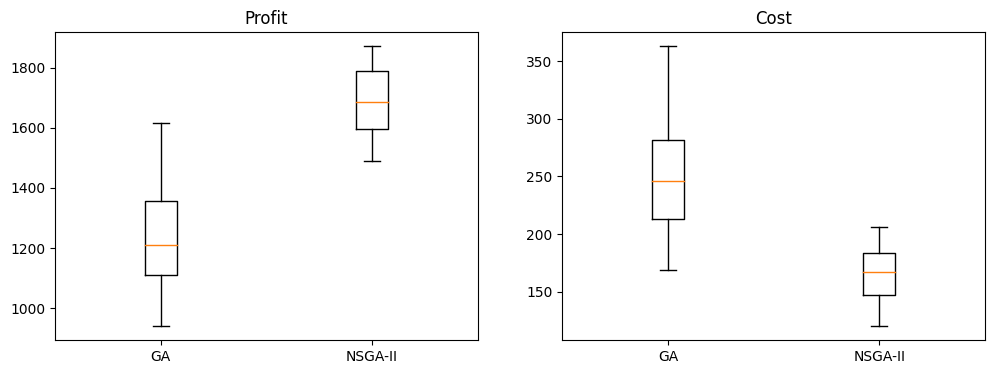

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].boxplot(results.values())
axes[0].set_xticklabels(results.keys())

results = {"GA"      : function2_ga, 
           "NSGA-II" : function2_values }
axes[1].boxplot(results.values())
axes[1].set_xticklabels(results.keys())

axes[0].set_title('Profit')
axes[1].set_title('Cost')

NSGA-II usually is able to produce solutions with higher profit and with lower costs. But what if we want a compromise, rather than extremes? The question really is whether the Pareto front itself covers different trade-offs better, so we need to move from comparing individual fitness values to comparing entire Pareto fronts.

## Comparing multi-objective optimisation algorithms

Comparison of the results of multi-objective algorithms is not as straightforward as comparing two scalar values. Empirical evaluation of different MOEAs becomes a meta-comparison: it is not only about the domain-specific quality, but it is also about the quality of the front itself. Properties that we want to evaluate are the closeness to the true Pareto front, as well as the diversity of the solutions on the Pareto front.  

### Closeness to the true front

For some problems, the true front is indeed known -- for example for benchmark problems which are specifically constructed to compare algorithms. If the true front is not known, it is also possible to approximate it by collecting all known solutions from all MOEAs involved, and extracting a single Pareto front from the collected solutions. 

Given a reference front $\Lambda = \{ y_1, y_2, \ldots, y_r\}$ (even if approximated) we can calculate the closeness of a solution set $V$ obtained by a MOEA using one of the following two metrics:


- IGD: average distance from each reference point to its closest solution.
$IGD(V,\Lambda) = \frac{1}{r}\left(\displaystyle\sum_{i=1}^r d(y_i, V)^2 \right)^{1/2}$

- GD: average distance from each solution to its closest reference point:
$GD(V, \Lambda) = IGD(\Lambda,V)$


These metrics represent how far the front produced by a search algorithm is from the true Pareto front $\lambda$. Lower values of GD/IGD represent better performance; IGD is usually preferred because it does not require any parts of the true Pareto set in the comparison.

In [69]:
from math import sqrt
def distance(solution, front):
    min_distance = None
    
    for y in front:
        a = solution.fitness1 - y.fitness1
        b = solution.fitness2 - y.fitness2
        d = sqrt(a*a + b*b)
        if min_distance == None or d < min_distance:
            min_distance = d
    
    return min_distance

In [70]:
def igd(front, reference_front):
    r = len(reference_front)

    sum_distances = 0
    for i in range(r):
        sum_distances += distance(reference_front[i], front) ** 2
    
    d = sqrt(sum_distances) / r
    
    return d

Let's set up an artificial example as above, with two fronts:

In [71]:
x1, x2, x3, x4, x5, x6, x7, x8 = L(1), L(2), L(3), L(4), L(5), L(6), L(7), L(8)

x1.fitness1, x1.fitness2 = 90, 50
x2.fitness1, x2.fitness2 = 60, 80
x3.fitness1, x3.fitness2 = 80, 60
x4.fitness1, x4.fitness2 = 50, 90

x5.fitness1, x5.fitness2 = 92, 95
x6.fitness1, x6.fitness2 = 99, 90
x7.fitness1, x7.fitness2 = 99, 90
x8.fitness1, x8.fitness2 = 95, 92

y1, y2 = L(1), L(2)
y1.fitness1, y1.fitness2 = 100, 99
y2.fitness1, y2.fitness2 = 99, 100

front1 = [x1, x2, x3, x4]
front2 = [x5, x6, x7, x8]

reference_front = [y1, y2]

As you may recall from the example above, `front2` is better than `front1`, and we would like to see this reflected in their `igd` values:

In [72]:
igd(front1, reference_front)

30.991934434623474

In [73]:
igd(front2, reference_front)

6.082762530298219

The generational distance is simply the inverse of `igd`:

In [74]:
def gd(front, reference_front):
    return igd(reference_front, front)

In [75]:
gd(front1, reference_front)

23.510635891017493

In [76]:
gd(front2, reference_front)

4.415880433163924

If we want to apply this to our Next Release Problem solutions, we first need to produce an approximate Pareto front:

In [77]:
merged_fronts = [] 
for front in fronts_nsgaii:
    merged_fronts.extend(front)
for front in solutions_ga:
    merged_fronts.extend(front)    
    
sorted_results = fast_non_dominated_sort(merged_fronts)[0]
reference_front = [merged_fronts[x] for x in sorted_results]

Now we can calculate the metrics for our solutions:

[Text(1, 0, 'GA'), Text(2, 0, 'NSGA-II')]

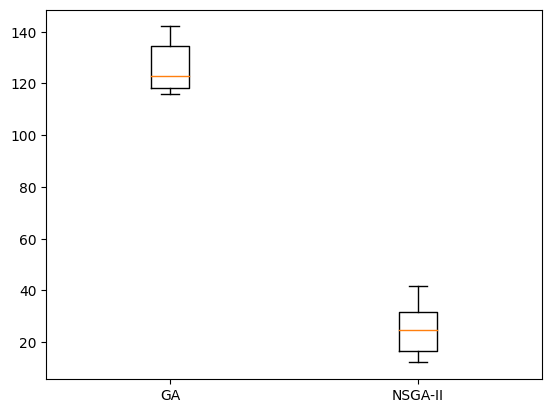

In [78]:
igd_ga = []
igd_nsgaii = []

for front in fronts_nsgaii:
    igd_nsgaii.append(igd(front, reference_front))
        
for solution in solutions_ga:
    igd_ga.append(igd(solution, reference_front))

results = {"GA"      : igd_ga, 
           "NSGA-II" : igd_nsgaii }

fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())

Since the distance for GA is higher, this means that the solution is further away from the (approximated) true Pareto front.

### Hypervolume

The generational distance metric is known to be problematic (see lecture slides). The hypervolume is an alternative metric that measures the area (space) dominated by a given Pareto front. It is a unary indicator as it does not need a reference front, but it does require a reference point.

A disadvantage of the hypervolume compared to the previous metrics is that it its calculation is more complex. However, for the 2-dimensional case (as in our example) it essentially boils down to calculating the sum of areas of rectangles in objective space defined by the points on the pareto front.

For our example fronts with fake points, let's assume our reference point is $(0,0)$. We thus need to calculate the area of the following rectangles:

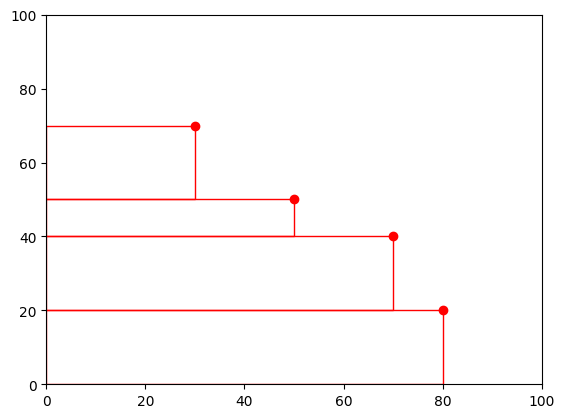

In [79]:
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

example_front = [(80, 20), (70, 40), (50, 50), (30, 70)]

plt.xlim(0, 100)
plt.ylim(0, 100)

plt.plot(example_front[0][0], example_front[0][1], 'ro')
plt.plot(example_front[1][0], example_front[1][1], 'ro')
plt.plot(example_front[2][0], example_front[2][1], 'ro')
plt.plot(example_front[3][0], example_front[3][1], 'ro')

ax = plt.gca()
rect = Rectangle((0, 0), example_front[0][0], example_front[0][1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
rect = Rectangle(example_front[1], -example_front[1][0], - (example_front[1][1] - example_front[0][1]), linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
rect = Rectangle(example_front[2], -example_front[2][0], - (example_front[2][1] - example_front[1][1]), linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
rect = Rectangle(example_front[3], -example_front[3][0], - (example_front[3][1] - example_front[2][1]), linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

That is, the hypervolume of a front $V = \{v^{(1)}, v^{(2)},\ldots, v^{(m)} \}$ with respect to reference point $r$ in this case reduces to calculating: $H(V, r) = (r_1 - v_1^{(1)})(r_2 - v_2^{(1)}) + \displaystyle\sum_{i=2}^m (r_1 - v_1^{(i)})(r_2^{(i-1)} - v_2^{(i)})$

In code, for our two objective values, this looks as follows:

In [80]:
def hypervolume(front, r):
    front.sort(key=lambda i: i.fitness1)
    
    hv = abs(r[0] - front[0].fitness1) * abs(r[1] - front[0].fitness2)
    
    for i in range(1, len(front)):
        hv += abs(r[0] - front[i].fitness1) * abs(front[i-1].fitness2 - front[i].fitness2)
    
    return hv

Note the use of the absolute value function: We need to use this if one dimension is minimising and the other is maximising in order to avoid getting negative values for the hypervolume.

In [81]:
hypervolume(front1, (0,0))

7600

In [82]:
hypervolume(front2, (0,0))

9223

As expected, this also confirms that `front2` is better than `front1`. Unlike the generational distance measures, the hypervolume gives us insights not only into the closeness to a reference front, but also the diversity of the solutions on the Pareto front.

We can again use the hypervolume to compare our GA results with those produced by the NSGA-II. For profit, the reference point is `0` because we are trying to maximise profit. For costs, however, the reference point is different, since we are trying to minimise it -- we can use `total_costs` as reference point, since this is the upper bound on fitness values for this function.

[Text(1, 0, 'GA'), Text(2, 0, 'NSGA-II')]

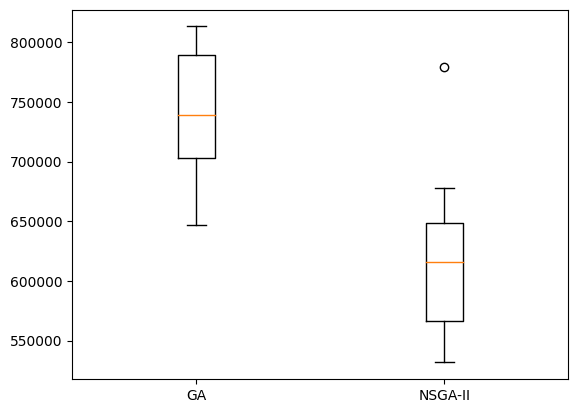

In [83]:
hv_ga = []
hv_nsgaii = []

for front in fronts_nsgaii:
    hv_nsgaii.append(hypervolume(front, (0,total_costs)))
        
for solution in solutions_ga:
    hv_ga.append(hypervolume(solution, (0,total_costs)))

results = {"GA"      : hv_ga, 
           "NSGA-II" : hv_nsgaii }

fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())

Since the GA only produces a single point, the hypervolume of NSGA-II is sometimes larger again, but not always.

### Normalisation

The concept of Pareto optimality itself is independent from scale and normalisation: it is strictly based on partial order only. For quality indicators, normalisation may be necessary so that multiple objectives contribute equally to the indicators. For example, we may want to make sure that profit and costs are weighted equally.

In [84]:
def hypervolume(front, r):
    front.sort(key=lambda i: i.fitness1)

    hv = (abs(r[0] - front[0].fitness1) / total_profit) * (abs(r[1] - front[0].fitness2) / total_costs)
    
    for i in range(1, len(front)):
        hv += (abs(front[i-1].fitness1 - front[i].fitness1) / total_profit) * (abs(r[1] - front[i].fitness2) / total_costs)
    
    return hv

Does it result in different hypervolumes?

[Text(1, 0, 'GA'), Text(2, 0, 'NSGA-II')]

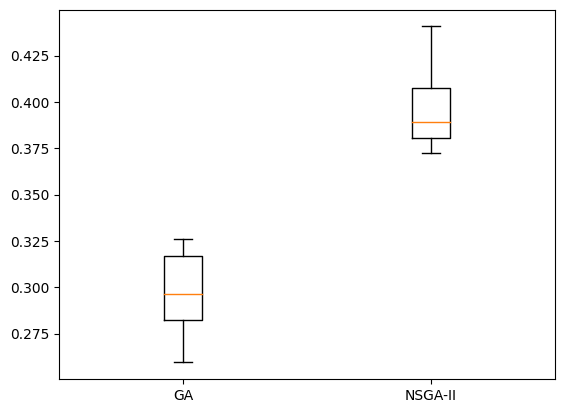

In [85]:
hv_ga = []
hv_nsgaii = []

for front in fronts_nsgaii:
    hv_nsgaii.append(hypervolume(front, (0,total_costs)))
        
for solution in solutions_ga:
    hv_ga.append(hypervolume(solution, (0,total_costs)))

results = {"GA"      : hv_ga, 
           "NSGA-II" : hv_nsgaii }

fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())

Now that we know how to compare MOEAs, in the next chapter will compare at a couple of different algorithms.